In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import keras
import numpy
from keras.preprocessing.image import ImageDataGenerator

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255, validation_split=0.2)


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!unzip gdrive/My\ Drive/state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

In [11]:
train_data = 'imgs/train'
test_data = 'imgs/test'
train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [12]:
from PIL import Image

ac_labels=  ["c0: safe driving",
"c1: texting - right",
"c2: talking on the phone - right",
"c3: texting - left",
"c4: talking on the phone - left",
"c5: operating the radio",
"c6: drinking",
"c7: reaching behind",
"c8: hair and makeup",
"c9: talking to passenger"]

In [13]:
imgs, labels = next(train_generator)

In [14]:
import functools

def list_counts(start_dir):
    lst = sorted(os.listdir(start_dir))
    out = [(fil, len(os.listdir( os.path.join(start_dir, fil)))) for fil in lst if os.path.isdir(os.path.join(start_dir,fil))]
    return out

out = list_counts(train_data)
labels, counts = zip(*out)
print("Total number of images : ",functools.reduce(lambda a,b : a+b, counts))
out

Total number of images :  22424


[('c0', 2489),
 ('c1', 2267),
 ('c2', 2317),
 ('c3', 2346),
 ('c4', 2326),
 ('c5', 2312),
 ('c6', 2325),
 ('c7', 2002),
 ('c8', 1911),
 ('c9', 2129)]

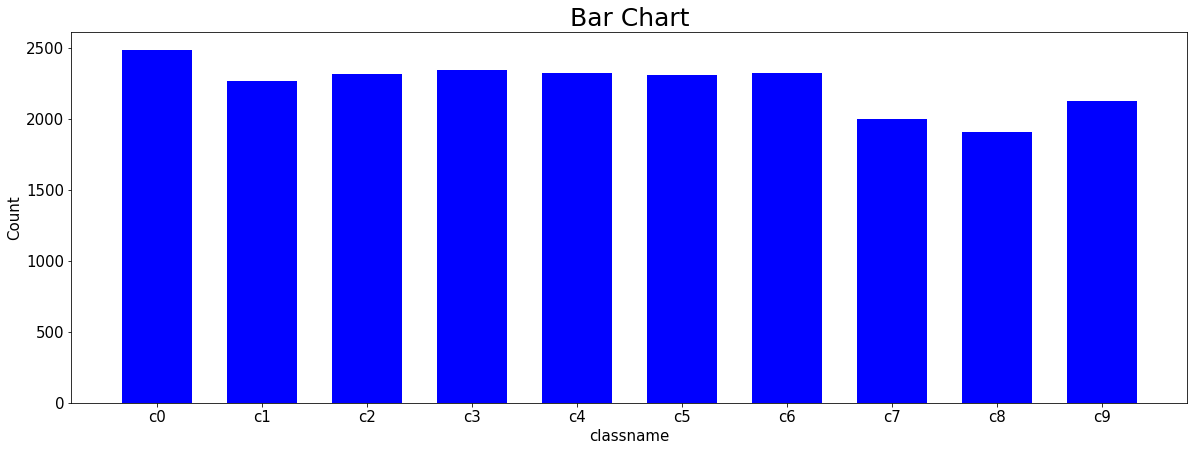

Label :  c0: safe driving


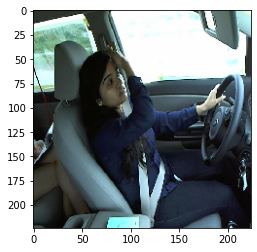

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline


y = np.array(counts)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)


plt.show()



def showImages(imgs ,inlabels=None, single=True):
    if single:
        aim = (imgs * 255 ).astype(np.uint8)
        img = Image.fromarray(aim)
        if labels is not None:
            print("Label : ", ac_labels[np.argmax(inlabels)])
        plt.imshow(img)
        plt.show()
    else:
        for i,img in enumerate(imgs):
            lbl = None
            if inlabels is not None:
                lbl = labels[i]
            showImages(img, lbl)

ind = 1
showImages(imgs[:ind], inlabels=labels[:ind], single = False)

In [26]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras import regularizers

In [27]:
def load_VGG16(weights_path=None, no_top=True):

    input_shape = (224, 224, 3)


    img_input = Input(shape=input_shape)   
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)


    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)


    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = GlobalAveragePooling2D()(x)
    vmodel = Model(img_input, x, name='vgg16')
    if weights_path is not None:
        print("Weights have been loaded.")
        vmodel.load_weights(weights_path)

    return vmodel

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16
model=VGG16(include_top=False , weights="imagenet")

In [29]:
vgg_model_raw = load_VGG16('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg_model = vgg_model_raw.output
#vgg_model = Flatten()(vgg_model)
vgg_model = Dense(5000, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(vgg_model)
#vgg_model = Dropout(0.1)(vgg_model)
#vgg_model = Dense(1000, activation='relu')(vgg_model)
vgg_model = Dropout(0.1)(vgg_model)
vgg_model = Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(vgg_model)
vgg_model = Dropout(0.1)(vgg_model)
vgg_model = Dense(10, activation='softmax')(vgg_model)
vgg_m = Model(inputs=vgg_model_raw.input, outputs= vgg_model)


Weights have been loaded.


In [34]:
import tensorflow as tf 

In [35]:
vgg_m.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(0.001), metrics=['accuracy'])

In [36]:
vgg_m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
checkpoint = ModelCheckpoint('vgg_model.h5', save_best_only=True, verbose=1)

history = vgg_m.fit_generator(train_generator, steps_per_epoch=len(train_generator),
                   epochs=6,
                   validation_data = val_generator,
                   validation_steps=len(val_generator),
                   callbacks=[checkpoint] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/6
 55/561 [=>............................] - ETA: 7:27:10 - loss: 2.3398 - accuracy: 0.1188

In [ ]:
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['loss'])